In [24]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [25]:
#import libraries
import tensorflow as tf
import pandas as pd
import re
import nltk
import zipfile
import os
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import pickle


In [26]:
#! pip install --upgrade tensorflow

In [27]:
print(tf.__version__)

2.15.0


In [28]:
# Function to check if GPU is available and set the device
def get_device():
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        device_name = physical_devices[0].name
        print(f"Running on GPU: {device_name}")
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    else:
        device_name = '/CPU:0'
        print("Running on CPU")
    return device_name


In [29]:
#load the training data
df = pd.read_csv(r'C:\Users\User\Desktop\deep learning project1\twitter_training.csv')

In [30]:
df

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [31]:
#load the testing data
test = pd.read_csv(r'C:\Users\User\Desktop\deep learning project1\twitter_test.csv')

In [32]:
test

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [33]:
#add headers
df.columns = ['Header1', 'source','class_labels','text']
test.columns = ['Header1', 'source','class_labels','text']
df

,Header1,source,class_labels,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [34]:
test

,Header1,source,class_labels,text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [35]:
#delete the header1 and source columns (not needed for the model)
df.drop(columns=['Header1','source'], inplace=True)
test.drop(columns=['Header1','source'], inplace=True)
df

,class_labels,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
74676,Positive,Just realized that the Windows partition of my...
74677,Positive,Just realized that my Mac window partition is ...
74678,Positive,Just realized the windows partition of my Mac ...
74679,Positive,Just realized between the windows partition of...


In [36]:
test

,class_labels,text
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...
994,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,Positive,Today sucked so it’s time to drink wine n play...
997,Positive,Bought a fraction of Microsoft today. Small wins.


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   class_labels  74681 non-null  object
 1   text          73995 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [38]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   class_labels  999 non-null    object
 1   text          999 non-null    object
dtypes: object(2)
memory usage: 15.7+ KB


In [39]:
#check for missing values
df.isnull().sum()

class_labels      0
text            686
dtype: int64

In [40]:
test.isnull().sum()

class_labels    0
text            0
dtype: int64

In [41]:
#drop missing values
df.dropna(inplace=True)
df.isnull().sum()

class_labels    0
text            0
dtype: int64

In [42]:
#check for duplicates
df.duplicated().sum()

4227

In [43]:
test.duplicated().sum()

1

In [44]:
#drop duplicates
df.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [45]:
test.duplicated().sum()

0

In [46]:
#nltk path
nltk_data_dir = r'C:\Users\User\Desktop\deep learning project1\nltk_rep'
wordnet_zip_path = os.path.join(nltk_data_dir, 'corpora/wordnet.zip')
omw_zip_path = os.path.join(nltk_data_dir, 'corpora/omw-1.4.zip')
wordnet_dir = os.path.join(nltk_data_dir, 'corpora/wordnet')
omw_dir = os.path.join(nltk_data_dir, 'corpora/omw-1.4')
punkt_dir = os.path.join(nltk_data_dir, 'corpora/punkt')
stopwords_dir = os.path.join(nltk_data_dir, 'corpora/stopwords')

for some reason it duplicates the wordnet and omw folders and i have to delele them manually

In [47]:
#check if the files are already downloaded
os.makedirs(nltk_data_dir, exist_ok=True)

In [48]:
#Download NLTK data if not already downloaded
if not os.path.exists(wordnet_zip_path):
    nltk.download('wordnet', download_dir=nltk_data_dir)
if not os.path.exists(omw_zip_path):
    nltk.download('omw-1.4', download_dir=nltk_data_dir)
if not os.path.exists(stopwords_dir):
    nltk.download('stopwords', download_dir=nltk_data_dir)
#if not os.path.exists(punkt_dir):
    #nltk.download('punkt', download_dir=nltk_data_dir)

#download Graphviz



In [49]:
#define function to unzip files
def unzip_file(zip_path, extract_to):
    if not os.path.exists(extract_to):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)

In [50]:
#unzip the downloaded files if not already unzipped
unzip_file(wordnet_zip_path, wordnet_dir)
unzip_file(omw_zip_path, omw_dir)

In [51]:
#add nlltk path
nltk.data.path.append(nltk_data_dir)

In [52]:
#define that the data is accessible
try:
    from nltk.corpus import wordnet
    print("WordNet is available.")
except Exception as e:
    print(f"Error accessing WordNet: {e}")

try:
    from nltk.corpus import wordnet
    # Access synsets to ensure OMW 1.4 is integrated
    example_synset = wordnet.synsets('example')
    if example_synset:
        print("OMW 1.4 data is integrated and available.")
    else:
        print("OMW 1.4 data is not found.")
except Exception as e:
    print(f"Error accessing OMW 1.4 data: {e}")
try:
    from nltk.corpus import stopwords
    print("Stopwords are available.")
except Exception as e:
    print(f"Error accessing Stopwords: {e}")
#try:
    #from nltk.tokenize.punkt import WordPunctTokenizer
    #print("punkt are available.")
#except Exception as e:
    #print(f"Error accessing punkt: {e}")

WordNet is available.
OMW 1.4 data is integrated and available.
Stopwords are available.


creating a function to clean the text

In [53]:
def process_text(text):
    #remove extra spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    #remove special characters
    text = re.sub(r'\W', ' ', str(text))
    #remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    #remove non alphabetical characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    text = text.lower()

    words = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    stop_words = set(stopwords.words("english"))
    Words = [word for word in words if word not in stop_words]

    Words = [word for word in Words if len(word) > 2]

    indices = np.unique(Words, return_index=True)[1]
    cleaned_text = np.array(Words)[np.sort(indices)].tolist()

    return cleaned_text

In [54]:
# get the text column to apply the function in  the training data
x=df.drop('class_labels',axis=1)
y=df.class_labels
texts=list(x['text'])

In [55]:
x

,text
0,I am coming to the borders and I will kill you...
1,im getting on borderlands and i will kill you ...
2,im coming on borderlands and i will murder you...
3,im getting on borderlands 2 and i will murder ...
4,im getting into borderlands and i can murder y...
...,...
74676,Just realized that the Windows partition of my...
74677,Just realized that my Mac window partition is ...
74678,Just realized the windows partition of my Mac ...
74679,Just realized between the windows partition of...


In [56]:
y

0        Positive
1        Positive
2        Positive
3        Positive
4        Positive
           ...   
74676    Positive
74677    Positive
74678    Positive
74679    Positive
74680    Positive
Name: class_labels, Length: 69768, dtype: object

In [57]:
texts

['I am coming to the borders and I will kill you all,',
 'im getting on borderlands and i will kill you all,',
 'im coming on borderlands and i will murder you all,',
 'im getting on borderlands 2 and i will murder you me all,',
 'im getting into borderlands and i can murder you all,',
 "So I spent a few hours making something for fun. . . If you don't know I am a HUGE @Borderlands fan and Maya is one of my favorite characters. So I decided to make myself a wallpaper for my PC. . Here is the original image versus the creation I made :) Enjoy! pic.twitter.com/mLsI5wf9Jg",
 "So I spent a couple of hours doing something for fun... If you don't know that I'm a huge @ Borderlands fan and Maya is one of my favorite characters, I decided to make a wallpaper for my PC.. Here's the original picture compared to the creation I made:) Have fun! pic.twitter.com / mLsI5wf9Jg",
 "So I spent a few hours doing something for fun... If you don't know I'm a HUGE @ Borderlands fan and Maya is one of my fav

In [58]:
# get the text column to apply the function in  the testing data
x_test=test.drop('class_labels',axis=1)
y_test=test.class_labels
texts_test=list(x_test['text'])

In [59]:
#clean the texts
cleaned_text = [process_text(text) for text in texts]
cleaned_text_test = [process_text(text) for text in texts_test]

In [60]:
cleaned_text

[['coming', 'border', 'kill'],
 ['getting', 'borderland', 'kill'],
 ['coming', 'borderland', 'murder'],
 ['getting', 'borderland', 'murder'],
 ['getting', 'borderland', 'murder'],
 ['spent',
  'hour',
  'making',
  'something',
  'fun',
  'know',
  'huge',
  'borderland',
  'fan',
  'maya',
  'one',
  'favorite',
  'character',
  'decided',
  'make',
  'wallpaper',
  'original',
  'image',
  'versus',
  'creation',
  'made',
  'enjoy',
  'pic',
  'twitter',
  'com',
  'mlsiwfjg'],
 ['spent',
  'couple',
  'hour',
  'something',
  'fun',
  'know',
  'huge',
  'borderland',
  'fan',
  'maya',
  'one',
  'favorite',
  'character',
  'decided',
  'make',
  'wallpaper',
  'original',
  'picture',
  'compared',
  'creation',
  'made',
  'pic',
  'twitter',
  'com',
  'mlsiwfjg'],
 ['spent',
  'hour',
  'something',
  'fun',
  'know',
  'huge',
  'borderland',
  'fan',
  'maya',
  'one',
  'favorite',
  'character'],
 ['spent',
  'hour',
  'making',
  'something',
  'fun',
  'know',
  'huge',

In [61]:
cleaned_text_test

[['bbc',
  'news',
  'amazon',
  'bos',
  'jeff',
  'bezos',
  'reject',
  'claim',
  'company',
  'acted',
  'like',
  'drug',
  'dealer',
  'busine'],
 ['microsoft', 'pay', 'word', 'function', 'poorly', 'samsungus', 'chromebook'],
 ['csgo',
  'matchmaking',
  'full',
  'closet',
  'hacking',
  'truly',
  'awful',
  'game'],
 ['president',
  'slapping',
  'american',
  'face',
  'really',
  'commit',
  'unlawful',
  'act',
  'acquittal',
  'discover',
  'google',
  'vanityfair',
  'com',
  'news'],
 ['eahelp',
  'madeleine',
  'mccann',
  'cellar',
  'past',
  'year',
  'little',
  'sneaky',
  'thing',
  'escaped',
  'whilst',
  'loading',
  'fifa',
  'point',
  'took',
  'card',
  'use',
  'paypal',
  'account',
  'working',
  'help',
  'resolve',
  'please'],
 ['thank',
  'eamaddennfl',
  'new',
  'austin',
  'hooper',
  'orange',
  'brown',
  'austinhooper',
  'pic',
  'twitter',
  'com',
  'grgxzfkon'],
 ['rocket',
  'league',
  'sea',
  'thief',
  'rainbow',
  'six',
  'siege',
 

In [62]:
# Convert cleaned_text back to DataFrame to keep consistent with labels
#cleaned_text_df = pd.DataFrame({'text': cleaned_text})
#cleaned_text_test_df = pd.DataFrame({'text': cleaned_text_test})

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(cleaned_text, y, test_size=0.1, random_state=42)

In [64]:
# Tokenize the text data
from tensorflow.keras.preprocessing.text import Tokenizer
max_vocab = 20000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_val)
tokenizer.fit_on_texts(cleaned_text_test)
word_idx = tokenizer.word_index  # Corrected syntax for accessing word index
v = len(word_idx)
print("the size of vocab =", v)  # Corrected spacing

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(cleaned_text_test)

the size of vocab = 26839


In [65]:
X_train

[[2265,
  5717,
  65,
  96,
  2909,
  293,
  1692,
  374,
  11495,
  482,
  22,
  63,
  1472,
  1060,
  4275,
  137,
  1096,
  24,
  3630,
  193,
  767],
 [222, 645],
 [283, 568, 2034, 2351, 62, 381, 95, 88, 5, 6, 1, 11496],
 [1323, 816, 419, 5346, 4854, 248, 205, 13, 125, 5, 6, 1, 15166],
 [3, 11497, 2352, 320, 69, 17, 318, 47, 316, 270],
 [673, 4136],
 [388,
  1632,
  3053,
  1775,
  6140,
  8185,
  1050,
  1044,
  18117,
  4276,
  251,
  3,
  547,
  337],
 [743, 3, 109, 110, 1005],
 [73, 797, 2, 1285],
 [19, 5088, 81, 37, 27, 4137, 1672, 1360],
 [101, 73, 29, 27, 14, 204, 256, 1],
 [1123,
  515,
  922,
  31,
  652,
  132,
  1177,
  425,
  2656,
  291,
  2437,
  3740,
  938,
  609,
  348,
  421,
  1612,
  1451,
  6960,
  6568,
  6141,
  8186,
  4452,
  1535,
  15167,
  3225,
  493,
  963,
  1216],
 [11498, 801, 1185, 35, 690, 7415, 1602, 393, 1129, 2353, 1038, 1178],
 [101, 3226, 73, 29, 11499, 14, 204, 256, 1],
 [403,
  210,
  309,
  62,
  49,
  100,
  1976,
  2705,
  650,
  126,
  

In [66]:
X_val

[[400,
  227,
  424,
  4,
  14,
  577,
  365,
  69,
  130,
  2,
  245,
  8,
  136,
  1262,
  280,
  60,
  261,
  2022,
  313],
 [92, 445, 6147],
 [889, 4951, 8856, 117, 406, 306, 1591, 39, 350, 4950, 32, 78, 2233],
 [14691,
  14692,
  7407,
  880,
  6558,
  2905,
  2635,
  167,
  464,
  303,
  366,
  181,
  293,
  5065,
  1684,
  14693,
  1985],
 [737, 1483, 2780],
 [19581],
 [590, 35, 174, 3791, 17, 376, 3101, 16, 163, 15],
 [734, 1990, 134, 46, 179, 483, 4150, 2771, 3064, 102, 41],
 [1792, 1591, 32, 361, 17],
 [16646, 58, 1455, 63],
 [114, 638, 295],
 [40, 2890, 167, 7, 16, 1508, 4, 398],
 [175, 189, 91, 402, 9, 831, 203, 2, 306, 9988, 845, 1184],
 [629, 68, 103, 1186, 240],
 [68, 42, 106, 5, 6, 1, 14954],
 [92, 238, 2, 1934, 921, 236, 2364, 120, 3609, 1842, 254, 13, 4488, 4],
 [106, 68, 2772, 1166, 13800, 620, 395, 189, 5, 6, 1, 16827],
 [753, 101, 280, 879, 281, 3, 17973, 29, 5, 6, 1, 17974],
 [39,
  134,
  213,
  3195,
  2,
  33,
  311,
  150,
  4,
  568,
  19,
  336,
  106,
  48,

In [67]:
X_test

[[1680, 96, 32, 1358, 1629, 2423, 3512, 694, 147, 4216, 3, 1145, 6677, 9807],
 [38, 267, 387, 2462, 2092, 12003, 5168],
 [119, 1491, 248, 7594, 2417, 516, 1120, 2],
 [1584, 5402, 671, 320, 12, 5010, 18081, 1078, 11705, 3168, 31, 8410, 1, 96],
 [734,
  7616,
  9013,
  4560,
  491,
  23,
  202,
  3407,
  59,
  9014,
  2848,
  917,
  46,
  179,
  366,
  150,
  186,
  2889,
  190,
  217,
  102,
  4076,
  41],
 [68, 76, 11, 3533, 11004, 3632, 2281, 5, 6, 1, 11005],
 [2496,
  95,
  1138,
  1480,
  1113,
  1069,
  840,
  10,
  28,
  425,
  141,
  19,
  72,
  10968,
  4853,
  385],
 [21, 4921, 1283, 124, 127, 423, 122, 2022, 313, 461],
 [60,
  1256,
  41,
  63,
  45,
  159,
  4412,
  18838,
  1179,
  270,
  1223,
  1105,
  1610,
  410,
  488,
  5,
  6,
  1,
  13846],
 [1562, 123, 1024, 36, 7867, 399, 502, 4, 639],
 [7689, 15838, 1057, 5, 6, 1],
 [17720, 195, 4951, 2403, 750, 1149, 35, 554, 876, 789, 5, 6, 1, 13713],
 [119, 3292, 1105, 290, 2756, 72, 14985],
 [107, 2, 226, 254, 427, 67, 3963, 4

In [68]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100
X_train = pad_sequences(X_train,maxlen=maxlen)
X_val = pad_sequences(X_val,maxlen=maxlen)
X_test = pad_sequences(X_test,maxlen=maxlen)

In [69]:
X_train

array([[    0,     0,     0, ...,  3630,   193,   767],
       [    0,     0,     0, ...,     0,   222,   645],
       [    0,     0,     0, ...,     6,     1, 11496],
       ...,
       [    0,     0,     0, ...,   269,   193,   411],
       [    0,     0,     0, ...,     0,  1666,   192],
       [    0,     0,     0, ...,    80,   726,    28]])

In [70]:
X_val

array([[    0,     0,     0, ...,   261,  2022,   313],
       [    0,     0,     0, ...,    92,   445,  6147],
       [    0,     0,     0, ...,    32,    78,  2233],
       ...,
       [    0,     0,     0, ...,   154,     2,  1148],
       [    0,     0,     0, ...,   164,    72, 16633],
       [    0,     0,     0, ...,    18, 17292,  9669]])

In [71]:
X_test

array([[    0,     0,     0, ...,  1145,  6677,  9807],
       [    0,     0,     0, ...,  2092, 12003,  5168],
       [    0,     0,     0, ...,   516,  1120,     2],
       ...,
       [    0,     0,     0, ...,   152,    22,   353],
       [    0,     0,     0, ...,    50,   518,   113],
       [    0,     0,     0, ...,  2767,    18, 10720]])

In [72]:
y.value_counts()

class_labels
Negative      21237
Positive      19137
Neutral       17110
Irrelevant    12284
Name: count, dtype: int64

In [73]:
# Set device
device = get_device()

Running on CPU


In [74]:
# Define the learning rate
def lr_schedule(epoch, lr):
    if epoch < 20:
        return 0.0001
    elif epoch < 40:
        return 0.00001
    elif epoch < 60:
        return 0.000001
    else:
        return 0.0000001

In [75]:
# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [76]:
D=100
# Define the input shape
inputt=Input(shape=(maxlen,))

In [77]:
# embedding layer
x = Embedding(input_dim=v+1, output_dim=D)(inputt)
x = Dropout(0.5)(x)  # Add dropout layer
x = Bidirectional(LSTM(150))(x)
x = Dense(32, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

In [78]:
# Define the model with the device
#with tf.device(device):
model = Model(inputs=inputt, outputs=x)

In [79]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          2684000   
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 bidirectional (Bidirection  (None, 300)               301200    
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                9632      
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                             

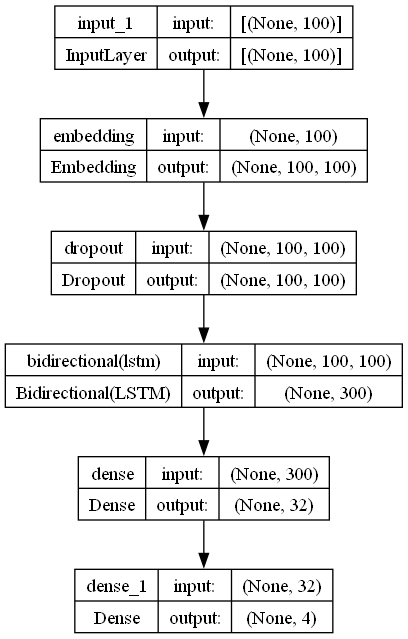

In [80]:
from keras.utils import plot_model
plot_model(model, to_file="model.png", show_shapes=True)

In [81]:
# Define optimizer with specified learning rate
learning_rate = 0.000001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the device being used
print(f"Using device: {device}")

Using device: /CPU:0


In [82]:
# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [83]:
y_train_encoded

array([0, 1, 3, ..., 1, 2, 3])

In [84]:
# Convert the encoded labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded)
y_val_one_hot = tf.keras.utils.to_categorical(y_val_encoded)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded)

In [85]:
y_train_one_hot

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [87]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_path = r'C:\Users\User\Desktop\deep learning project1\LSTM200_5_sentiment_model.h5'

training/loading

In [89]:
# Check if the model already exists to avoid retraining
try:
        trained_model = tf.keras.models.load_model(model_path)
        print(f"Model loaded from {model_path}")
except IOError:
        model_checkpoint = ModelCheckpoint(filepath=model_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   mode='min',
                                   save_weights_only=False,
                                   verbose=1)
        # Train the model
        history = model.fit(X_train, y_train_one_hot, epochs=800,batch_size=128, validation_data=(X_val, y_val_one_hot), callbacks=[early_stopping, model_checkpoint, lr_scheduler])
        # Save the model after training
        model.save(model_path)
        with open(r'C:\Users\User\Desktop\deep learning project1\history.pkl', 'wb') as file:
            pickle.dump(history, file)
        print(f"Model saved to {model_path}")
        trained_model = tf.keras.models.load_model(model_path)

Model loaded from C:\Users\User\Desktop\deep learning project1\LSTM200_5_sentiment_model.h5


In [90]:
#with open(r'C:\Users\User\Desktop\deep learning project1\history.pkl', 'rb') as file:
   #history = pickle.load(file)

ValueError: Layer 'embedding' expected 1 variables, but received 0 variables during loading. Expected: ['embedding/embeddings:0']

In [91]:
y_train_pred = trained_model.predict(X_train)
y_train_pred

1963/1963 [==============================] - 117s 59ms/step


array([[9.9984407e-01, 5.7055564e-07, 1.2456307e-04, 3.0827323e-05],
       [3.7059389e-02, 7.5725931e-01, 3.6889296e-02, 1.6879207e-01],
       [3.2990137e-03, 4.2813321e-04, 1.3143862e-04, 9.9614149e-01],
       ...,
       [2.0464158e-04, 9.9585330e-01, 3.4943470e-03, 4.4767838e-04],
       [2.4483469e-03, 3.1188607e-02, 9.6300274e-01, 3.3603392e-03],
       [1.2147013e-03, 3.2379854e-04, 7.3776334e-03, 9.9108386e-01]],
      dtype=float32)

In [92]:
y_train_pred.shape

(62791, 4)

In [93]:
y_test_one_hot.shape

(998, 4)

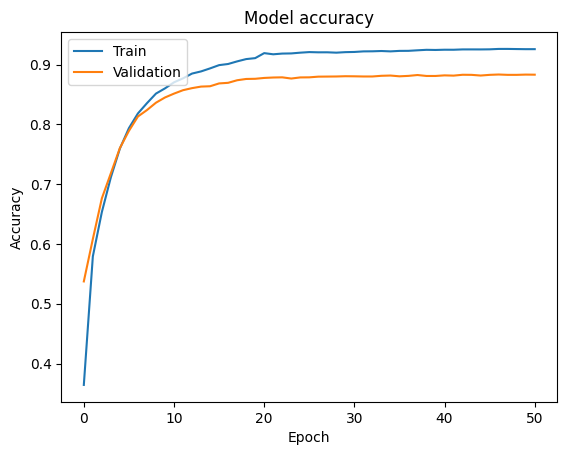

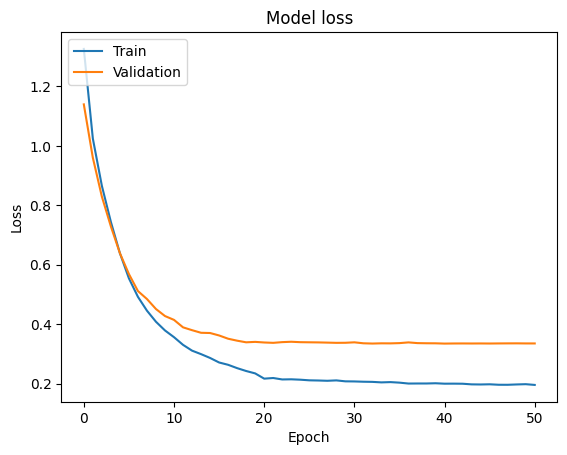

In [ ]:
# Plot training & validation accuracy values
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.title('Model accuracy')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')
#plt.legend(['Train', 'Validation'], loc='upper left')
#plt.show()

# Plot training & validation loss values
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('Model loss')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.legend(['Train', 'Validation'], loc='upper left')
#plt.show()

In [94]:
X_test

array([[    0,     0,     0, ...,  1145,  6677,  9807],
       [    0,     0,     0, ...,  2092, 12003,  5168],
       [    0,     0,     0, ...,   516,  1120,     2],
       ...,
       [    0,     0,     0, ...,   152,    22,   353],
       [    0,     0,     0, ...,    50,   518,   113],
       [    0,     0,     0, ...,  2767,    18, 10720]])

In [95]:
model_probs = trained_model.predict(X_test)

###model_pred = (model_probs >= 0.5).astype(int)###
model_pred = np.zeros_like(model_probs)
# Find the index of the maximum probability in each row
max_indices = np.argmax(model_probs, axis=1)
# Set the maximum probability position to 1
model_pred[np.arange(model_probs.shape[0]), max_indices] = 1
print(model_pred)

32/32 [==============================] - 2s 52ms/step
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


In [96]:
# Flatten the arrays for evaluation
y_true = y_test_one_hot.flatten()
y_pred = model_pred.flatten()

In [97]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [98]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

In [99]:
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9785
Precision: 0.9713
Recall: 0.9713
F1 Score: 0.9713


In [100]:
# Print detailed classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2994
         1.0       0.96      0.96      0.96       998

    accuracy                           0.98      3992
   macro avg       0.97      0.97      0.97      3992
weighted avg       0.98      0.98      0.98      3992



In [118]:
sample = "i kill my neighbor and i will play dota2 all night" 
sample = process_text(sample)
sample = tokenizer.texts_to_sequences([sample])
sample = pad_sequences(sample, maxlen=maxlen)
sample = trained_model.predict(sample)
model_pred = np.zeros_like(sample)
max_indices = np.argmax(sample, axis=1)
model_pred[np.arange(sample.shape[0]), max_indices] = 1
print(model_pred)

1/1 [==============================] - 0s 47ms/step
[[0. 0. 0. 1.]]
